# An example use case : a hybrid quantum-classical machine learning model

-  In this example a quantum circuit is used to generate features, which are then fed into a classical machine learning model for training and prediction.

# Importing the necessary libraries

In [1]:
pip install amazon-braket-sdk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from braket.aws import AwsDevice
from braket.circuits import Circuit

# Define the S3 bucket and folder which contains the results of the various quantum circuits 

In [5]:
quantumbucket = "amazon-braket-us-east-1-614646524231"
foldername = "tasks/"
s3_folder=(quantumbucket,foldername)

# Choose the local simulator provided by Amazon Braket

Here is a list of all supported Braket devices : https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html

In [6]:
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

# Load in dataset

- The iris dataset is a dataset containing 150 samples of the iris flower. 
- Each sample has 4 features (sepal length, sepal width, petal length, petal width)
- The dataset contains 3 species of the iris flower where each sample is labelled to be one of the 3(Iris-setosa, Iris-versicolor, Iris-virginica)

In [7]:
iris = datasets.load_iris()
# Only take the first two features for simplicity
X = iris.data[:, :2]
# Binary classification: 0 if setosa species, 1 otherwise
y = np.where(iris.target == 0, 0, 1) 

# Split dataset into training set and test set
- Only the first 10 samples are used for training and testing so as to save on time
- 70% (0.7) of the dataset is used for training and 30% (0.3) of the dataset is used for testing

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train = X_train[:10]  
y_train = y_train[:10]
X_test = X_test[:10] 
y_test = y_test[:10]

# Standardize features

- Aligning the features of the training and testing sets to have a mean of 0 and standard deviation of 1

In [9]:
sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Quantum feature map
- The function encodes classical data into quantum states which can be processed by a quantum computer
- A quantum circuit is generated, it can be broken down as follows:
- ".ry(0, x[0])" --> Rotate qubit 0 around the Y-axis by an angle of x[0] -> Bloch sphere rotation
- ".ry(1, x[1])" --> Rotate qubit 1 around the Y-axis by an angle of x[1] -> Bloch sphere rotation
- ".cnot(0, 1)" --> Apply CNOT gate to qubits 0 and 1, introducing entanglement between qubits 0 and 1, creating a correlation between their states
- ".ry(1, x[0]+x[1])" --> Rotates qubit 1 around the Y-axis by an angle of x[0] + x[1] (or the sum of the 2 features of the data point x) --> Bloch sphere rotation


In [10]:
def quantum_feature_map(x):
    # Create a  quantum circuit
    circuit = Circuit().ry(0, x[0]).ry(1, x[1]).cnot(0, 1).ry(1, x[0]+x[1])
    task = device.run(circuit, s3_folder, shots=1000)
    result = task.result()
    counts = result.measurement_counts
    # Use the probabilities of the measured states as features
    return [counts.get('0', 0)/1000, counts.get('1', 0)/1000]


# Transform data using quantum feature map

- Call the quantum_feature_map function to convert the standardised classical datasets into quantum training and test datasets

In [11]:
X_train_quantum = np.array([quantum_feature_map(x) for x in X_train_std])
X_test_quantum = np.array([quantum_feature_map(x) for x in X_test_std])

# Train a classical SVM classifier

- The Support Vector Machine (SVM) machine learning algorithm is widely used for classification (as in this example where the dataset is classified into binary data, i.e 0 for setosa species and 1 otherwise) and regression tasks.
- The SVM algorithm makes decisions by finding the hyperplane (in 2D case a line, 3D case a plane and so on) that best separates the classes in the input feature space.
- The SVM classifer makes predictions on new, unseen data based on this hyperplane

In [12]:
classifier = SVC(kernel='linear')
classifier.fit(X_train_quantum, y_train)

SVC(kernel='linear')

# Print accuracy of classification

In [13]:
accuracy = classifier.score(X_test_quantum, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 80.00%


# Plot decision boundary

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


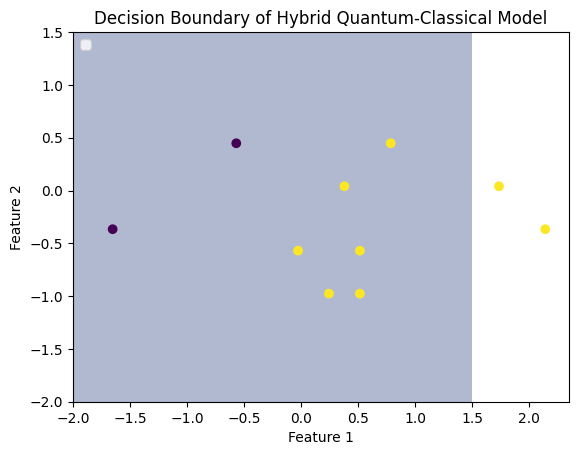

In [14]:
xx, yy = np.meshgrid(np.arange(-2, 2, 0.5), np.arange(-2, 2, 0.5))
Z = classifier.predict(np.array([quantum_feature_map(x) for x in np.c_[xx.ravel(), yy.ravel()]]))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_test_std[:, 0], X_test_std[:, 1], c=y_test, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary of Hybrid Quantum-Classical Model')
plt.show()